In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
# Change the style of plot
plt.style.use('seaborn-darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [22]:
# Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler

# Train Test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve,confusion_matrix

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import log_loss, classification_report
from sklearn.model_selection import train_test_split

In [5]:
import os
save_folder = "../figures/neural_net/"
os.path.isdir(save_folder)

True

In [6]:
filename = '../datasets/heart.csv'
df = pd.read_csv(filename)

In [7]:
df.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [8]:
# creating a copy of df
df1_copy = df

# define the columns to be encoded and scaled (defined before)
categorial_features = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
continuous_features = ["age","trtbps","chol","thalachh","oldpeak"]

# encoding the categorical columns (one hot encoding)
df1_copy = pd.get_dummies(df1_copy, columns = categorial_features, drop_first = True)

# seperate features with target
X = df1_copy.drop(['output'],axis=1)
y = df1_copy[['output']]
# instantiating the scaler
scaler = RobustScaler()
# scaler = StandardScaler()

# scaling the continuous featuree
X[continuous_features] = scaler.fit_transform(X[continuous_features])

In [9]:
#separate data for testing and training 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)
y_train = y_train.squeeze(1)
y_test = y_test.squeeze(1)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)

The shape of X_train is       (227, 22)
The shape of X_test is        (76, 22)
The shape of y_train is       (227,)
The shape of y_test is        (76,)


In [11]:
from mlrose_hiive.algorithms.decay import ExpDecay
from mlrose_hiive.neural import NeuralNetwork

In [12]:
def plot_helper(x_axis, y_axis, label):
    """Plot helper.
        Args:
          x_axis (ndarray): x axis to plot over.
          y_axis (ndarray): y axis to plot.
          label (ndarray): label.
        Returns:
          None.
        """

    y_mean, y_std = np.mean(y_axis, axis=0), np.std(y_axis, axis=0)
    plot = plt.plot(x_axis, y_mean, label=label)
    plt.fill_between(x_axis, y_mean - y_std, y_mean + y_std, alpha=0.1, color=plot[0].get_color())


def set_plot_title_labels(title, x_label, y_label):
    """Set plot title and labels.
        Args:
          title (string): plot title.
          x_label (string): x label.
          y_label (string): y label.
        Returns:
          None.
        """
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel(x_label)
    plt.ylabel(y_label)


In [20]:
def plot_nn_performances(x_train, y_train, random_seeds, **kwargs):
    """Plot Neural Networks performances on the training set.
        Use different optimizations algorithms (RHC, SA, GA and GD) and compare results on the training set using
        k-fold cross-validation.
        Args:
        x_train (ndarray): training data.
        y_train (ndarray): training labels.
        random_seeds (list or array): random seeds for multiple random runs to use for k-fold cross-validation.
        kwargs (dict): additional arguments to pass for curves plotting:
                  - rhc_max_iters (list or ndarray): RHC list or array of maximum number of iterations to plot vs.
                  - sa_max_iters (list or ndarray): SA list or array of maximum number of iterations to plot vs.
                  - ga_max_iters (list or ndarray): GA list or array of maximum number of iterations to plot vs.
                  - gd_max_iters (list or ndarray): GD list or array of maximum number of iterations to plot vs.
                  - init_temp (float): SA initial temperature.
                  - exp_decay_rate (float): SA temperature exponential decay rate.
                  - min_temp (float): SA minimum temperature.
                  - pop_size (int): GA population size.
                  - mutation_prob (float): GA mutation probability.
        Returns:
        None.
           """

    # Initialize algorithms, corresponding acronyms and max number of iterations
    algorithms = ['random_hill_climb', 'simulated_annealing', 'genetic_alg', 'gradient_descent']
    acronyms = ['RHC', 'SA', 'GA', 'GD']
    max_iters = ['rhc_max_iters', 'sa_max_iters', 'ga_max_iters', 'gd_max_iters']

    # Initialize lists of training curves, validation curves and training times curves
    train_curves, val_curves, train_time_curves = [], [], []

    # Define SA exponential decay schedule
    exp_decay = ExpDecay(init_temp=kwargs['init_temp'],
                         exp_const=kwargs['exp_decay_rate'],
                         min_temp=kwargs['min_temp'])

    # Create one figure for training and validation losses, the second for training time
    plt.figure()
    train_val_figure = plt.gcf().number
    plt.figure()
    train_times_figure = plt.gcf().number

    # For each of the optimization algorithms to test the Neural Network with
    for i, algorithm in enumerate(algorithms):
        print('\nAlgorithm = {}'.format(algorithm))

        # For multiple random runs
        for random_seed in random_seeds:

            # Initialize training losses, validation losses and training time lists for current random run
            train_losses, val_losses, train_times = [], [], []

            # Compute stratified k-fold
            x_train_fold, x_val_fold, y_train_fold, y_val_fold = train_test_split(x_train, y_train,
                                                                                  test_size=0.2, shuffle=True,
                                                                                  random_state=random_seed,
                                                                                  stratify=y_train)
            # For each max iterations to run for
            for max_iter in kwargs[max_iters[i]]:

                # Define Neural Network using current algorithm
                nn = NeuralNetwork(hidden_nodes=[10,], activation='relu',
                                   algorithm=algorithm, max_iters=int(max_iter),
                                   bias=True, is_classifier=True, learning_rate=0.001,
                                   early_stopping=False, clip_max=1e10, schedule=exp_decay,
                                   pop_size=kwargs['pop_size'], mutation_prob=kwargs['mutation_prob'],
                                   max_attempts=int(max_iter), random_state=random_seed, curve=False)

                # Train on current training fold and append training time
                start_time = time.time()
                nn.fit(x_train_fold, y_train_fold)
                train_times.append(time.time() - start_time)

                # Compute and append training and validation log losses
                train_loss = log_loss(y_train_fold, nn.predict(x_train_fold))
                val_loss = log_loss(y_val_fold, nn.predict(x_val_fold))
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print('{} - train loss = {:.3f}, val loss = {:.3f}'.format(max_iter, train_loss, val_loss))

            # Append curves for current random seed to corresponding lists of curves
            train_curves.append(train_losses)
            val_curves.append(val_losses)
            train_time_curves.append(train_times)

        # Plot training and validation figure for current algorithm
        plt.figure(train_val_figure)
        plot_helper(x_axis=kwargs[max_iters[i]], y_axis=np.array(train_curves), label='{} train'.format(acronyms[i]))
        plot_helper(x_axis=kwargs[max_iters[i]], y_axis=np.array(val_curves), label='{} val'.format(acronyms[i]))

        # Plot training time figure for current algorithm
        plt.figure(train_times_figure)
        plot_helper(x_axis=kwargs[max_iters[i]], y_axis=np.array(train_time_curves), label=acronyms[i])

    # Set title and labels to training and validation figure
    plt.figure(train_val_figure)
    set_plot_title_labels(title='Neural Network - Loss vs. iterations',
                                x_label='Iterations',
                                y_label='Loss')

    # Save figure
    plt.savefig(save_folder + 'nn_objective_vs_iterations')

    # Set title and labels to training time figure
    plt.figure(train_times_figure)
    set_plot_title_labels(title='Neural Network - Time vs. iterations',
                                x_label='Iterations',
                                y_label='Time (seconds)')

    # Save figure
    plt.savefig(save_folder + 'nn_time_vs_iterations')


Algorithm = random_hill_climb
1 - train loss = 15.075, val loss = 15.768
5 - train loss = 15.075, val loss = 15.768
10 - train loss = 15.075, val loss = 15.768
50 - train loss = 15.075, val loss = 15.768
100 - train loss = 15.075, val loss = 15.768
150 - train loss = 15.075, val loss = 15.768
300 - train loss = 14.884, val loss = 15.768
500 - train loss = 14.884, val loss = 15.768
1 - train loss = 16.029, val loss = 14.266
5 - train loss = 16.029, val loss = 14.266
10 - train loss = 16.029, val loss = 14.266
50 - train loss = 16.029, val loss = 14.266
100 - train loss = 16.029, val loss = 14.266
150 - train loss = 16.029, val loss = 14.266
300 - train loss = 16.029, val loss = 14.266
500 - train loss = 16.029, val loss = 14.266
1 - train loss = 16.602, val loss = 14.266
5 - train loss = 16.602, val loss = 14.266
10 - train loss = 16.602, val loss = 14.266
50 - train loss = 16.602, val loss = 14.266
100 - train loss = 16.602, val loss = 14.266
150 - train loss = 16.602, val loss = 14.2

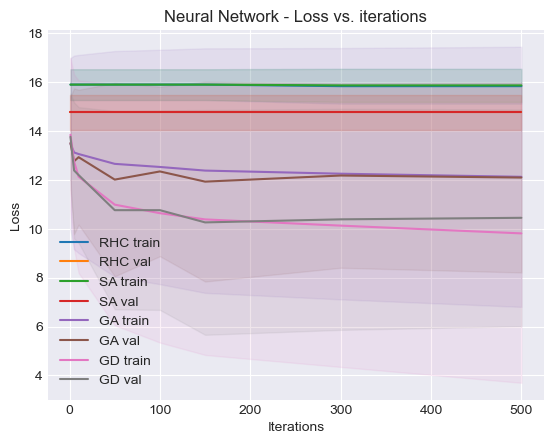

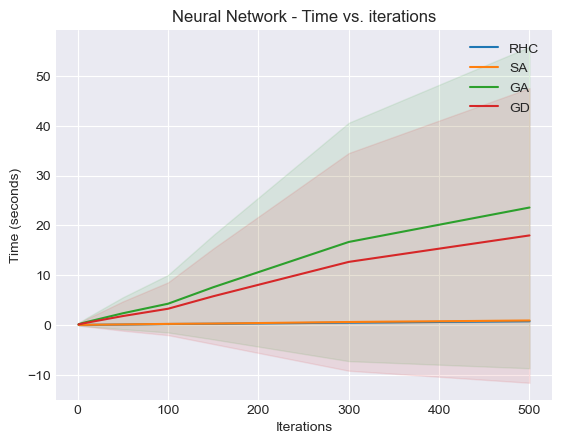

In [23]:
random_seeds = [7,102,3] 
# Maximum iterations to run the Neural Network for
iterations = np.array([1,5,10,50,100,150,300,500])

# Plot performances for RHC, SA, GA and GD with Neural Networks
plot_nn_performances(X_train, y_train,
                        random_seeds=random_seeds,
                        rhc_max_iters=iterations, sa_max_iters=iterations,
                        ga_max_iters=iterations, gd_max_iters=iterations,
                        init_temp=100, exp_decay_rate=0.1, min_temp=0.001,
                        pop_size=100, mutation_prob=0.2)